# EDA
#### Análisis Exploratorio de los Datos para la elección un Modelo de Clasificación de un Sistema de Recomendación de Peliculas por Similaridad

### Indice:
1. Introducción
2. Objetivos
3. Estadística Descriptiva
4. Reducción de dimensionalidad I
5. Análisis de correlación
6. Agrupación de datos y tokenización
7. Nubes de Palabras de la variable objetivo
8. Reducción de dimensionalidad II
9. Tratamiento de Outliers
10. Factibilidad de posibles modelos
11. Similitud del coseno
12. Observaciones y Conclusiones

### 1. Introducción
##### El presente notebook trata acerca del análisis estadístico de los datos que nos permitirá sacar inferencias e hipotesis para un modelo de clasificación 
##### Se trabajará con datos de Features de películas en el cual se extraerán patrones y hallazgos para tener una mayor comprensión de los mismos.
##### Para el modelo del sistema de recomendación se tomará como variable objetivo "title"

### 2. Objetivos
##### 2.1 Determinar patrones y variables reelevantes en función a la variable objetivo
##### 2.2 Determinar los posibles modelos de clasificación 
##### 2.3 Sustentar las variables involucradas para el modelo de clasificación más factible

### 3.  Estadística Descriptiva

In [49]:
# Se importan las bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

In [50]:
# Se ingesta el dataset preprocesado
df = pd.read_csv('data_set/ds_clean.csv')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45451 entries, 0 to 45450
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4497 non-null   object 
 1   budget                 45451 non-null  int64  
 2   genres                 43067 non-null  object 
 3   id                     45451 non-null  int64  
 4   original_language      45440 non-null  object 
 5   overview               44510 non-null  object 
 6   popularity             45451 non-null  float64
 7   production_companies   33634 non-null  object 
 8   production_countries   39232 non-null  object 
 9   release_date           45451 non-null  object 
 10  revenue                45451 non-null  int64  
 11  runtime                45451 non-null  int64  
 12  spoken_languages       41554 non-null  object 
 13  status                 45371 non-null  object 
 14  tagline                20425 non-null  object 
 15  ti

In [52]:
# df.head()

#### 3. Análisis de Correlación

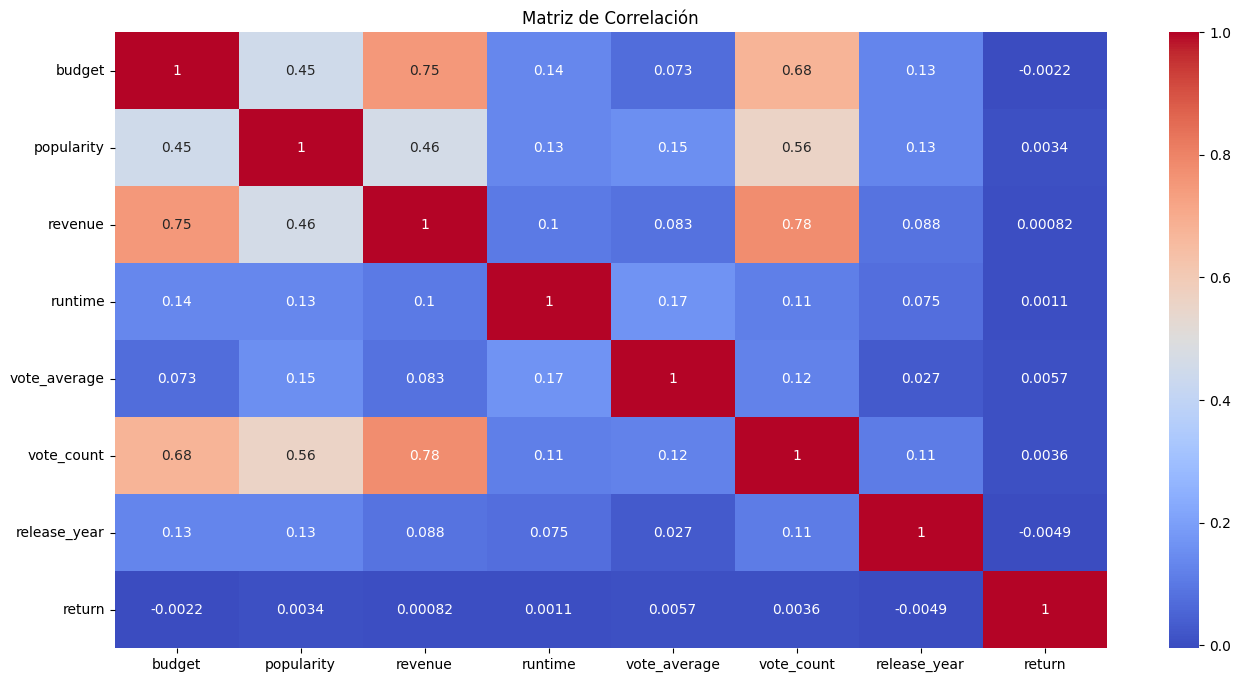

In [53]:
df = df.drop('id', axis = 1)
data_num= df.select_dtypes(exclude = ['object'])
data_num.head(2)

correlation_matrix = data_num.corr()

plt.figure(figsize=(16,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Hay solo algunas correlaciones significativas para mencionarlas:
- A mayor badget hay mayor revenue
- A mayor puntaje de votos en las películas hay mayor popularidad
- A mayor duración de la película hay menor Revenue y popularidad

#### 4. Reducción de Dimensionalidad I:
##### A) Criterio de eliminación por ratio de valores perdidos:
- Proporción de entre valores NAN y el número de registros es menor a 0.02 o 2%
##### B) Criterio de eliminación por el tipo de información acerca de película:
- Las variables no aportan información acerca de la naturaleza del contenido de cada película
- Las variables no explican la similaridad de contenido entre las películas


In [54]:
# df.isnull().sum()/len(df)

In [55]:
# Eliminación por el criterio B descrito lineas arriba
df = df.drop('revenue', axis = 1)
df = df.drop('release_year', axis = 1)
df = df.drop('release_date', axis = 1)
df = df.drop('budget', axis = 1)
df = df.drop('original_language', axis = 1)
df = df.drop('runtime', axis = 1)
df = df.drop('production_countries', axis = 1)
df = df.drop('spoken_languages', axis = 1)
df = df.drop('return', axis =1)

In [56]:
def filtrar_columnas_nulas(df):
    umbral_proporcion = 0.02
    num_filas = len(df)
    columnas_filtradas = []

    for columna in df.columns:
        if df[columna].isnull().sum() == 0:  # Las columnas que no tienen nulos se mantienen
            continue
        else:
            num_nulos = df[columna].isnull().sum()  # Se cuenta el número de nulos en la columna
            proporcion_nulos = num_nulos / num_filas

            if proporcion_nulos < umbral_proporcion:
                columnas_filtradas.append(columna)

    df.drop(columns=columnas_filtradas, inplace=True)  # Eliminar las columnas del dataframe

    print('Se filtraron las siguientes columnas:', columnas_filtradas)

    return df  # Retorna el dataframe actualizado

In [57]:
df = filtrar_columnas_nulas(df)

Se filtraron las siguientes columnas: ['status', 'crew', 'director']


#### 5. Estadistica Descriptiva

In [58]:
# Medidas de Tendencia central de variables numéricas
df.describe(include=[np.number])

,popularity,vote_average,vote_count
count,45451.000000,45451.000000,45451.000000
mean,2.926887,5.624085,109.989703
std,6.006458,1.915424,491.352336
min,0.000000,0.000000,0.000000
25%,0.389095,5.000000,3.000000
50%,1.131386,6.000000,10.000000
75%,3.694370,6.800000,34.000000
max,547.488298,10.000000,14075.000000


- Esta tres variables podrían ser potencialmente redundantes

In [59]:
# Caraterísticas de las variables numéricas categóricas
df.describe(include=object)

,belongs_to_collection,genres,overview,production_companies,tagline,title,cast
count,4497,43067,44510,33634,20425,45451,43097
unique,1695,4064,44231,22666,20269,42195,42656
top,The Bowery Boys,Drama,No overview found.,Metro-Goldwyn-Mayer (MGM),Which one is the first to return - memory or t...,Blackout,Georges Méliès
freq,29,5006,133,742,9,13,24


#### 6. Agrupación de datos y Tokenización

##### Para efectos de agrupamiento para modelos de clasificación, se pueden utilizar las siguientes agrupaciones:
- Variables categóricas que indican características unicas de cada película, como la trama, las categorias y etiquetas adicionales: _'overview', 'genres'_
- Variables categóricas como actores principales que ayudan a encontrar la relacion entre las películas: _'cast'_
- variables numericas que indican las preferencia por medio de votos a cada pelicula: _'popularity'_

Se requiere visualizar el comportamientos las palabras más usadas de la variable 'title'

In [60]:
# Se procede a tokenizar la variable objetivo
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    if isinstance(texto, float):  # Verificar si el valor es de tipo float
        return []  # Devolver una lista vacía en caso de que sea float

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [61]:
# Se aplica la función de limpieza y tokenización a cada pelicula
df_title = df
df_title['title_tokenizado'] =df_title['title'].apply(lambda x: limpiar_tokenizar(x))
df_title[['title', 'title_tokenizado']].head()

,title,title_tokenizado
0,Toy Story,"[toy, story]"
1,Jumanji,[jumanji]
2,Grumpier Old Men,"[grumpier, old, men]"
3,Waiting to Exhale,"[waiting, to, exhale]"
4,Father of the Bride Part II,"[father, of, the, bride, part, ii]"


In [62]:
# Generación de una nueva columna 'token'
title_tidy = df_title.explode(column='title_tokenizado')
title_tidy = title_tidy.drop(columns='title')
title_tidy = title_tidy.rename(columns={'title_tokenizado':'token'})

In [63]:
# Se descarga el paquete Stopwords de la biblioteca nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
from nltk.corpus import stopwords
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [65]:
# Filtrado para excluir stopwords
title_tidy = title_tidy[~(title_tidy["token"].isin(stop_words))]

#### 7. Nube de palabras de la variable objetivo

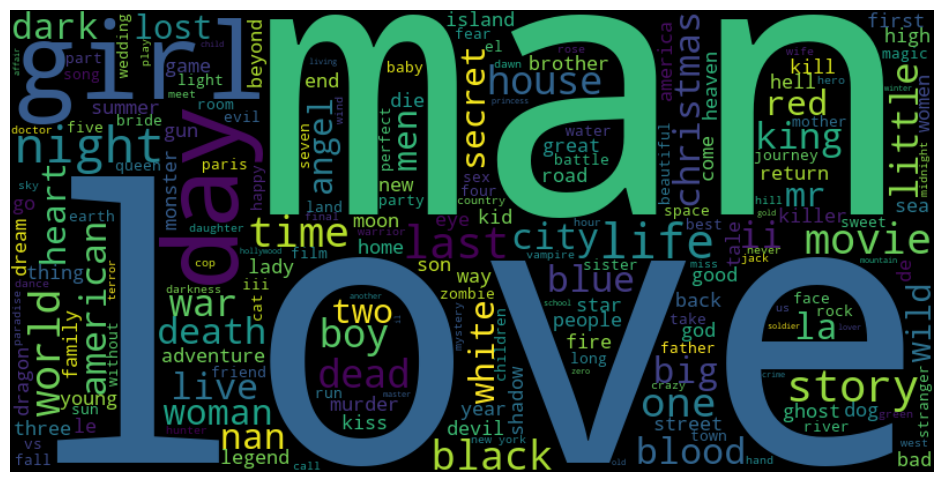

In [66]:
from wordcloud import WordCloud
# Unir todos los tokens en un solo texto
all_tokens = ' '.join(title_tidy['token'].astype(str))

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_tokens)

# Mostrar la nube de palabras
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Las palabras más repetidas son: Love, man, girl, story, night, movie, girl, last, one, time, litle, house, death, american y day

In [67]:
df.head()

,belongs_to_collection,genres,overview,popularity,production_companies,tagline,title,vote_average,vote_count,cast,title_tokenizado
0,Toy Story Collection,"Animation, Comedy, Family","Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,NaN,Toy Story,7.7,5415.0,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","[toy, story]"
1,NaN,"Adventure, Fantasy, Family",When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",[jumanji]
2,Grumpy Old Men Collection,"Romance, Comedy",A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","[grumpier, old, men]"
3,NaN,"Comedy, Drama, Romance","Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"Whitney Houston, Angela Bassett, Loretta Devin...","[waiting, to, exhale]"
4,Father of the Bride Collection,Comedy,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"Steve Martin, Diane Keaton, Martin Short, Kimb...","[father, of, the, bride, part, ii]"


#### 8. Reducción de dimensionalidad II 

Reducción Vertical

In [68]:
# Se selecciona una sola variable de las tres por correlación
variables = ['popularity', 'vote_average', 'vote_count']
df_selected = df[variables]
correlation_matrix = df_selected.corr()
print(correlation_matrix)

              popularity  vote_average  vote_count
popularity      1.000000      0.153814    0.559846
vote_average    0.153814      1.000000    0.123556
vote_count      0.559846      0.123556    1.000000


In [69]:
df = df.drop('vote_average', axis =1)
df = df.drop('vote_count', axis =1)

- De las variables numericas, las tres indican una puntuación, dos de ellas tienen una correlación. Se va a conservar 'popularity' porque proviene de los datos extraidos de la cantidad de vistas
. Sin embargo, los votos tienden a tener un sesgo, por la misma naturaleza de recolección

Reducción Horizontal

In [70]:
# Contar la frecuencia de cada película en la columna 'title'
peliculas_repetidas = df['title'].value_counts()

# Filtrar las películas que se repiten
peliculas_repetidas = peliculas_repetidas[peliculas_repetidas > 1]

# Obtener el número de películas repetidas
num_peliculas_repetidas = len(peliculas_repetidas)

print("Número de películas que se repiten:", num_peliculas_repetidas)

Número de películas que se repiten: 2339


In [71]:
# Se borran los duplicados y se mantienen las primeras apariciones
df.drop_duplicates(subset='title', keep='first', inplace=True)


In [72]:
# Verificar si hay películas repetidas
hay_repetidas = df['title'].duplicated().any()

if hay_repetidas:
    print("Hay películas repetidas en el dataframe.")
else:
    print("No hay películas repetidas en el dataframe.")

No hay películas repetidas en el dataframe.


- En el contexto de reducción de variables categóricas, se identifica que la variable objetivo 'title' es crucial para el modelo de clasificación. Por lo tanto, se facilita el proceso de filtrado al eliminar directamente las filas que contienen valores repetidos en 'title'

#### 9. Tratamiento de Outliers

En base a que solo hay uina variable numérica, _'popularity'_. Se observará su comportamiento usando un histograma y un diagrama de dispersión.

In [76]:
df['popularity'].describe()

count    42195.000000
mean         2.914161
std          5.744714
min          0.000000
25%          0.387433
50%          1.136152
75%          3.718018
max        547.488298
Name: popularity, dtype: float64

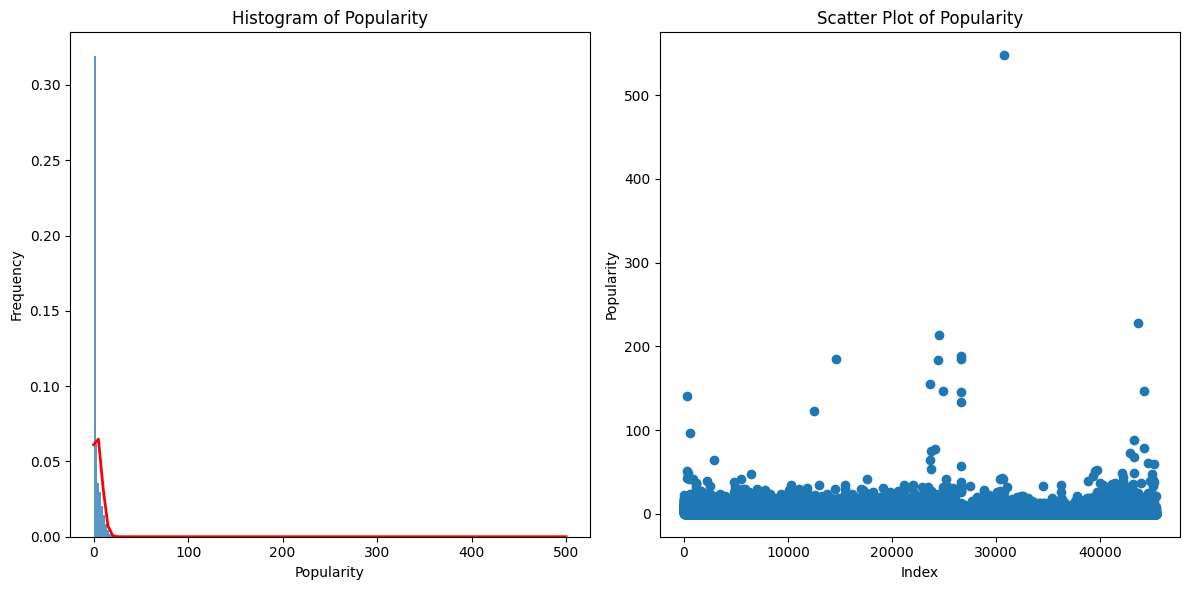

In [83]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Crear una figura con dos subtramas en la misma fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histograma
ax1.hist(df['popularity'], bins=50, range=(0, 100), density=True, alpha=0.75)
ax1.set_xlabel('Popularity')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Popularity')

# Generar los valores para la línea de la campana de Gauss
mu, sigma = df['popularity'].mean(), df['popularity'].std()
x = np.linspace(0, 500, 100)
y = norm.pdf(x, mu, sigma)  # Función de densidad de probabilidad

# Trazar la línea de la campana de Gauss
ax1.plot(x, y, 'r-', linewidth=2)

# Diagrama de dispersión
ax2.scatter(df.index, df['popularity'])
ax2.set_xlabel('Index')
ax2.set_ylabel('Popularity')
ax2.set_title('Scatter Plot of Popularity')

# Ajustar el espaciado entre las subtramas
plt.tight_layout()

# Mostrar la figura
plt.show()


Claramente se observa outliers. Se tienen que tratar para un análisis futuro

#### 10. Factibilidad de posibles Modelos de Clasificación

Para un sistema de recomendación de películas basado, hay varios modelos de machine learning que sepuede considerar, considerando las siguientes tres variables:
 _'overview', 'popularity' y ' title'_

Entre las opciones más populares estan opciones populares:

- Fuerza bruta o basado en reglas: Puedes implementar un enfoque simple basado en reglas o fuerza bruta. Por ejemplo, podrías buscar coincidencias exactas o similares en los títulos de las películas y recomendar aquellas que sean más cercanas.

- Bag of Words (BoW) y TF-IDF: Se puede utilizar técnicas de procesamiento de lenguaje natural como el modelo de bolsa de palabras (Bag of Words) o TF-IDF para representar el texto del título de las películas como características numéricas y luego aplicar algoritmos de clasificación o recomendación como Similitud del coseno, Naive Bayes, Árboles de Decisión, K-Nearest Neighbors (KNN) o Support Vector Machines (SVM).

- Word Embeddings: Se puede utilizar modelos de word embeddings pre-entrenados, como Word2Vec, GloVe o FastText, para representar los títulos de las películas en un espacio semántico y luego aplicar algoritmos de clasificación o recomendación como KNN, clustering o modelos de aprendizaje profundo.

- Aprendizaje profundo: Se puede utilizar modelos de aprendizaje profundo como redes neuronales convolucionales (CNN) o redes neuronales recurrentes (RNN), como LSTM o GRU, para aprender representaciones más complejas de los títulos de las películas y generar recomendaciones basadas en estas representaciones.

- Modelos de recomendación basados en contenido: Se puede utilizar enfoques de filtrado colaborativo o sistemas de recomendación basados en contenido. Por ejemplo, podrías construir un perfil de película para cada usuario basado en los títulos de las películas que ha visto y luego recomendar películas similares en función de la similitud entre los perfiles.


#### 10.1 Tres posibles escenarios:

##### 10.1.1 Escenario Eficiente:
Se pueden usar moedelos como KNN o Gráfico de Palabras. la técnica BoW permite determinar la asociación más cercana dentro de un conjunto de palabras en este caso asociadas a una combinación entre titlo de las peliculas y las palabra de las reseñas.

##### 10.1.2 Escenario Efectivo:
Se pueden usar los Vectores del Coseno usando las tres variables. Este enfoque es efectivo ya que aprovecha tanto la información textual como la numérica de las películas. Utilizar las características de texto permite capturar el contenido y el contexto de las películas, mientras que la característica numérica (popularidad) puede influir en las recomendaciones basadas en preferencias populares.

##### 10.1.3 Escenario Complejo
Se puede usar una Red Neuronal Convolucional(CNN) combinando las columnas "title", "overview" y "popularity" para crear una representación combinada de texto y características numéricas. Seguidamente ser procesadas utilizando capas convolucionales y capas densas para procesar y clasificar los datos para finalmente someterlas a validaciones standar para ese modelo.

11. #### Conclusiones

- Las tres variables más reelevantes para el modelo de clasificación son las variables: _"title", "overview" y "popularity"_

- Las columnas "title", "overview" pueden ser combinadas y además ser usadas como BoW (bolsas de palabras) para modelos de clasificación.

- los datos de la columna popularity tienen bastante dispersión y datos outliers, pero pueden ser usados como ultimo parámetro al momento de generar recomendaciones.

- Se optará por el escenario más efectivo, pero durante el proceso se evaluará si se va a usar la variable popularity, ya que depende mucho de factores como el tamaño del modelo para el deployement.